# Classifying NC vs PAE - Pre-trained SFCN Model - Using Processed MRI

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.stats import norm
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, AddChanneld, RandRotated, Lambda, ToTensor

In [2]:
# Keeping all file names in the list.
NC_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\NC_Resized_MRI"
PAE_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\PAE_Resized_MRI"

in_X = []
out_y = []

for file_name in os.listdir(NC_MRI_path):
    in_X.append(NC_MRI_path + "/" + file_name)
    out_y.append(0)
    
for file_name in os.listdir(PAE_MRI_path):
    in_X.append(PAE_MRI_path + "/" + file_name)
    out_y.append(1)
    
print(len(in_X), len(out_y))

401 401


In [3]:
X = []
y = []

for i in range(0, len(in_X), +1):
    mri = nib.load(in_X[i])
    data = mri.get_fdata()
    
    # Adding an extra dimension at the begining. From (160,192,160) to (1,160,192,160).
    data = data[np.newaxis, ...]
    
    X.append(data)
    y.append(out_y[i])
    
# Converting to numpy array.   
X = np.array(X)
y = np.array(y)

print(X[0].shape)
print(y[0].shape)

(1, 160, 192, 160)
()


# Simple Fully Convolutional Network (SFCN) Architecture

In [4]:
class SFCN(nn.Module):
    def __init__(self, channel_number):  # channel_number = [28, 58, 128, 256, 256, 64]
        super(SFCN, self).__init__()
        
        n_layer = len(channel_number)
        
        self.feature_extractor = nn.Sequential()
        
        for i in range(n_layer):
            if i == 0:
                in_channel = 1
            else:
                in_channel = channel_number[i-1]
                
            out_channel = channel_number[i]
            
            if i < n_layer-1:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 1))
            else:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = False, kernel_size = 1, padding = 0))
    
    
    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 0, maxpool_stride = 2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU(),
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer
    

    def forward(self, input_image):
        extracted_features = self.feature_extractor(input_image) 
        
        return extracted_features   #shape: [64,5,6,5]
    

channel_number = [28, 58, 128, 256, 256, 64] # Sex-prediction
#channel_number = [32, 64, 128, 256, 256, 64] # Brain-Age-prediction

model = SFCN(channel_number)

# Loading pre-trained model - Removing weights and biases for Classification Part

In [5]:
tm = "BSP_run_20191008_00_epoch_last.p" # Pre-trained model aka weights and biases of already trained model for sex prediction.
#tm = "BAP_run_20190719_00_epoch_best_mae.p" # This is for Brain Age prediction.
state_dict = torch.load(tm)

for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [6]:
# Removing weight and bias (parameters) of classifier layer.
state_dict.pop('module.classifier.conv_6.weight', None)
state_dict.pop('module.classifier.conv_6.bias', None)

tensor([ 0.0604, -0.0605], device='cuda:0')

In [7]:
# Printing weights and biases parameter shape after removing classifier.
for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [8]:
# Loading after removing the classificaiton part
model.load_state_dict(state_dict, strict = False)
model

SFCN(
  (feature_extractor): Sequential(
    (conv_0): Sequential(
      (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_1): Sequential(
      (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_2): Sequential(
      (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_3): Seque

# Freezing Feature Extraction Layers of Pre-trained SFCN Model


In [9]:
for param in model.parameters():
    param.requires_grad = False

# Adding a Classification Layer on Top of SFCN Architecture

In [10]:
def create_model():
    # Number of node in the final layer
    num_classes = 1

    # Defining the modified model by adding layers
    modified_model = nn.Sequential(
        model, # pre-trained SFCN model (feature extractor) for feature extraction
        nn.Flatten(),
        nn.Linear(9600, 512),  # number of output features from the pre-trained model: 64*5*6*5 = 9600
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
        nn.Sigmoid()  # Using Sigmoid activation for binary classification
    )
    
    return modified_model

modified_model = create_model()
modified_model

Sequential(
  (0): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Creating Dataset, Dataloader -- 5-Fold Train-Val-Test

In [11]:
# 5-Fold cross-validation method to train, validate and test the model
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# Initializing list to keep info of each fold
train_loss_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []

# Initializing lists to store results for all folds
all_true_labels = []
all_predicted_labels = []
fold_sensitivities = []
fold_specificities = []
    
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}:\n")
    
    # Creating train, val, test dataset
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=fold+1)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=fold+1)
    
    X_train_NC = X_train[y_train == 0]
    X_train_PAE = X_train[y_train == 1]
    
    
    train_data_dict_NC = [{"mri": a, "label": b} for a, b in zip(X_train_NC, np.zeros(len(X_train_NC)))]
    train_data_dict_PAE = [{"mri": a, "label": b} for a, b in zip(X_train_PAE, np.ones(len(X_train_PAE)))]
    val_data_dict = [{"mri": a, "label": b} for a, b in zip(X_val, y_val)]
    test_data_dict = [{"mri": a, "label": b} for a, b in zip(X_test, y_test)]
    
    train_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            RandRotated(keys=["mri"], prob=1),
            ToTensor()
        ])

    val_test_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            ToTensor()
        ])

    train_dataset_NC = Dataset(train_data_dict_NC, val_test_transforms)
    train_dataset_PAE = Dataset(train_data_dict_PAE, train_transforms)
    train_dataset = ConcatDataset([train_dataset_NC, train_dataset_PAE])

    val_dataset = Dataset(val_data_dict, val_test_transforms)
    test_dataset = Dataset(test_data_dict, val_test_transforms)

    
    train_count_zero = len(y_train) - np.count_nonzero(y_train)
    train_count_one = np.count_nonzero(y_train)
    val_count_zero = len(y_val) - np.count_nonzero(y_val)
    val_count_one = np.count_nonzero(y_val)
    test_count_zero = len(y_test) - np.count_nonzero(y_test)
    test_count_one = np.count_nonzero(y_test)
    
    print("NC and PAE ratio in training dataset: ", [train_count_zero, train_count_one])
    print("NC and PAE ratio in validation dataset: ", [val_count_zero, val_count_one])
    print("NC and PAE ratio in testing dataset: ", [test_count_zero, test_count_one])
    print("\n")
    
    # create the datasets and dataloaders
    #train_dataset = Creating_Dataset(X_train, y_train)
    #val_dataset = Creating_Dataset(X_val, y_val)
    #test_dataset = Creating_Dataset(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Initializing model. Need to initialize the model for each fold.
    modified_model = create_model()

    # Defining the loss function, optimizer, and metrics
    loss_fn = nn.BCELoss() #for sigmoind, output channel = 1
    optimizer = torch.optim.Adam(modified_model.parameters(), lr=0.001)
    
    # Creating list to keep loss and acc for each epoch
    train_loss_100epochs = []
    val_loss_100epochs = []
    test_acc_100epochs = []
    
    # Initializing lists to store results for each epoch in the fold
    fold_true_labels = []
    fold_predicted_labels = []

    num_epochs = 100

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        ############### Training on Train Set ###############
        modified_model.train()
        modified_model.cuda()

        for train_batch_idx, train_batch_data in enumerate(train_dataloader):
            train_input, train_actual_output = train_batch_data["mri"], train_batch_data["label"]
                                    
            train_input = train_input.cuda()
            train_actual_output = train_actual_output.cuda()

            optimizer.zero_grad()
            
            # Forward pass
            train_pred_output = modified_model(train_input)
            loss = loss_fn(train_pred_output, train_actual_output)

            # Backward and optimize
            loss.backward()
            train_loss = train_loss + loss.item()
            optimizer.step()

        train_loss = train_loss / (train_batch_idx + 1)

        ############### Evaluating on Validation Set ###############
        with torch.no_grad():
            modified_model.eval()
            modified_model.cuda()
            
            for val_batch_idx, val_batch_data in enumerate(val_dataloader):
                val_input, val_actual_output = val_batch_data["mri"], val_batch_data["label"]
                
                val_input = val_input.cuda()
                val_actual_output = val_actual_output.cuda()

                val_pred_output = modified_model(val_input)
                loss = loss_fn(val_pred_output, val_actual_output)
                val_loss = val_loss + loss.item()

            val_loss = val_loss / (val_batch_idx + 1)
        
        ############### Testing on Test Set ###############
        with torch.no_grad():
            total_sample = 0
            test_accuracy_total = 0

            for test_batch_data in test_dataloader:
                test_input, test_actual_output = test_batch_data["mri"], test_batch_data["label"]
                
                test_input = test_input.cuda()
                test_actual_output = test_actual_output.cuda()

                test_pred_output = modified_model(test_input)
                test_pred_output = torch.round(test_pred_output)
                
                # Append true and predicted labels for each sample in the test set
                fold_true_labels.extend(test_actual_output.cpu().numpy())
                fold_predicted_labels.extend(test_pred_output.cpu().numpy())

                # Calculating accuracy
                total_sample += test_actual_output.size(0)
                test_accuracy_total += (test_pred_output == test_actual_output).sum().item()

            accuracy = 100 * test_accuracy_total / total_sample

        train_loss_100epochs.append(train_loss)
        val_loss_100epochs.append(val_loss)
        test_acc_100epochs.append(accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(epoch+1, train_loss, val_loss, accuracy))
    
    # Keeping loss for each fold. Each fold has the loss for 100 epochs.
    train_loss_per_fold.append(train_loss_100epochs)
    val_loss_per_fold.append(val_loss_100epochs)
    
    # Keeping the Average accuracy for each fold. (sum of 100 epochs accuracy / 100 epochs)
    test_acc_per_fold.append(np.mean(test_acc_100epochs))
    
    # Calculate confusion matrix, sensitivity, and specificity for the current fold
    fold_confusion_matrix = confusion_matrix(fold_true_labels, fold_predicted_labels)
    tn, fp, fn, tp = fold_confusion_matrix.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print or store the results for the current fold
    print(f'Fold {fold+1} - Sensitivity: {sensitivity}, Specificity: {specificity}')

    # Append the true and predicted labels for the current fold to the overall lists
    all_true_labels.extend(fold_true_labels)
    all_predicted_labels.extend(fold_predicted_labels)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    
# Concatenate the confusion matrices from all folds
all_confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
tn, fp, fn, tp = all_confusion_matrix.ravel()

overall_sensitivity = tp / (tp + fn)
overall_specificity = tn / (tn + fp)

# Print or store the overall results
print(f'\nOverall Sensitivity: {overall_sensitivity}, Overall Specificity: {overall_specificity}')
print(f'Average Sensitivity across folds: {np.mean(fold_sensitivities)}, Average Specificity across folds: {np.mean(fold_specificities)}')


Fold 1:

NC and PAE ratio in training dataset:  [226, 94]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [24, 16]




C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.234167 	Validation Loss: 0.571881 	Test Accuracy: 72.500000
Epoch: 2 	Training Loss: 0.609807 	Validation Loss: 0.629715 	Test Accuracy: 72.500000
Epoch: 3 	Training Loss: 0.506123 	Validation Loss: 0.470965 	Test Accuracy: 75.000000
Epoch: 4 	Training Loss: 0.454479 	Validation Loss: 0.427807 	Test Accuracy: 62.500000
Epoch: 5 	Training Loss: 0.426221 	Validation Loss: 0.438999 	Test Accuracy: 65.000000
Epoch: 6 	Training Loss: 0.349974 	Validation Loss: 0.447623 	Test Accuracy: 77.500000
Epoch: 7 	Training Loss: 0.390887 	Validation Loss: 0.440521 	Test Accuracy: 75.000000
Epoch: 8 	Training Loss: 0.298940 	Validation Loss: 0.473027 	Test Accuracy: 62.500000
Epoch: 9 	Training Loss: 0.268186 	Validation Loss: 0.365633 	Test Accuracy: 82.500000
Epoch: 10 	Training Loss: 0.242709 	Validation Loss: 0.496719 	Test Accuracy: 72.500000
Epoch: 11 	Training Loss: 0.197634 	Validation Loss: 0.396427 	Test Accuracy: 72.500000
Epoch: 12 	Training Loss: 0.192367 	Valid

Epoch: 95 	Training Loss: 0.074838 	Validation Loss: 0.441611 	Test Accuracy: 80.000000
Epoch: 96 	Training Loss: 0.074562 	Validation Loss: 0.446028 	Test Accuracy: 82.500000
Epoch: 97 	Training Loss: 0.154389 	Validation Loss: 0.614385 	Test Accuracy: 85.000000
Epoch: 98 	Training Loss: 0.105106 	Validation Loss: 0.301263 	Test Accuracy: 82.500000
Epoch: 99 	Training Loss: 0.114598 	Validation Loss: 0.430930 	Test Accuracy: 82.500000
Epoch: 100 	Training Loss: 0.044591 	Validation Loss: 0.320468 	Test Accuracy: 85.000000
Fold 1 - Sensitivity: 0.6375, Specificity: 0.9383333333333334

Fold 2:

NC and PAE ratio in training dataset:  [222, 98]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [28, 12]




C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.283311 	Validation Loss: 0.617647 	Test Accuracy: 70.000000
Epoch: 2 	Training Loss: 0.526456 	Validation Loss: 0.657244 	Test Accuracy: 67.500000
Epoch: 3 	Training Loss: 0.444252 	Validation Loss: 0.536428 	Test Accuracy: 77.500000
Epoch: 4 	Training Loss: 0.438076 	Validation Loss: 0.629988 	Test Accuracy: 75.000000
Epoch: 5 	Training Loss: 0.351042 	Validation Loss: 0.509316 	Test Accuracy: 77.500000
Epoch: 6 	Training Loss: 0.378562 	Validation Loss: 0.463199 	Test Accuracy: 80.000000
Epoch: 7 	Training Loss: 0.309363 	Validation Loss: 0.548609 	Test Accuracy: 80.000000
Epoch: 8 	Training Loss: 0.271198 	Validation Loss: 0.428752 	Test Accuracy: 72.500000
Epoch: 9 	Training Loss: 0.254300 	Validation Loss: 0.527039 	Test Accuracy: 75.000000
Epoch: 10 	Training Loss: 0.223657 	Validation Loss: 0.354780 	Test Accuracy: 85.000000
Epoch: 11 	Training Loss: 0.163420 	Validation Loss: 0.633802 	Test Accuracy: 85.000000
Epoch: 12 	Training Loss: 0.124449 	Valid

Epoch: 95 	Training Loss: 0.138296 	Validation Loss: 0.526550 	Test Accuracy: 90.000000
Epoch: 96 	Training Loss: 0.121476 	Validation Loss: 0.517826 	Test Accuracy: 90.000000
Epoch: 97 	Training Loss: 0.124599 	Validation Loss: 0.782439 	Test Accuracy: 80.000000
Epoch: 98 	Training Loss: 0.151165 	Validation Loss: 0.407846 	Test Accuracy: 90.000000
Epoch: 99 	Training Loss: 0.151131 	Validation Loss: 0.516785 	Test Accuracy: 90.000000
Epoch: 100 	Training Loss: 0.176763 	Validation Loss: 0.598790 	Test Accuracy: 87.500000
Fold 2 - Sensitivity: 0.5725, Specificity: 0.9660714285714286

Fold 3:

NC and PAE ratio in training dataset:  [221, 99]
NC and PAE ratio in validation dataset:  [29, 12]
NC and PAE ratio in testing dataset:  [29, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.353553 	Validation Loss: 0.472885 	Test Accuracy: 87.500000
Epoch: 2 	Training Loss: 0.586542 	Validation Loss: 0.578575 	Test Accuracy: 67.500000
Epoch: 3 	Training Loss: 0.471308 	Validation Loss: 0.412521 	Test Accuracy: 85.000000
Epoch: 4 	Training Loss: 0.461492 	Validation Loss: 0.396705 	Test Accuracy: 75.000000
Epoch: 5 	Training Loss: 0.372168 	Validation Loss: 0.646896 	Test Accuracy: 75.000000
Epoch: 6 	Training Loss: 0.354483 	Validation Loss: 0.353248 	Test Accuracy: 80.000000
Epoch: 7 	Training Loss: 0.315915 	Validation Loss: 0.297094 	Test Accuracy: 87.500000
Epoch: 8 	Training Loss: 0.288341 	Validation Loss: 0.497317 	Test Accuracy: 75.000000
Epoch: 9 	Training Loss: 0.261102 	Validation Loss: 0.224882 	Test Accuracy: 92.500000
Epoch: 10 	Training Loss: 0.191157 	Validation Loss: 0.232145 	Test Accuracy: 95.000000
Epoch: 11 	Training Loss: 0.198728 	Validation Loss: 0.221958 	Test Accuracy: 95.000000
Epoch: 12 	Training Loss: 0.183835 	Valid

Epoch: 95 	Training Loss: 0.151271 	Validation Loss: 0.261209 	Test Accuracy: 97.500000
Epoch: 96 	Training Loss: 0.178199 	Validation Loss: 0.553207 	Test Accuracy: 85.000000
Epoch: 97 	Training Loss: 0.147600 	Validation Loss: 0.968198 	Test Accuracy: 95.000000
Epoch: 98 	Training Loss: 0.161877 	Validation Loss: 0.240779 	Test Accuracy: 95.000000
Epoch: 99 	Training Loss: 0.175312 	Validation Loss: 0.281706 	Test Accuracy: 90.000000
Epoch: 100 	Training Loss: 0.210705 	Validation Loss: 0.228200 	Test Accuracy: 90.000000
Fold 3 - Sensitivity: 0.7745454545454545, Specificity: 0.9793103448275862

Fold 4:

NC and PAE ratio in training dataset:  [219, 101]
NC and PAE ratio in validation dataset:  [34, 7]
NC and PAE ratio in testing dataset:  [26, 14]




C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.217518 	Validation Loss: 0.430416 	Test Accuracy: 67.500000
Epoch: 2 	Training Loss: 0.549801 	Validation Loss: 0.469633 	Test Accuracy: 67.500000
Epoch: 3 	Training Loss: 0.524288 	Validation Loss: 0.390286 	Test Accuracy: 70.000000
Epoch: 4 	Training Loss: 0.465850 	Validation Loss: 0.268717 	Test Accuracy: 67.500000
Epoch: 5 	Training Loss: 0.455614 	Validation Loss: 0.298114 	Test Accuracy: 65.000000
Epoch: 6 	Training Loss: 0.374116 	Validation Loss: 0.320912 	Test Accuracy: 80.000000
Epoch: 7 	Training Loss: 0.297679 	Validation Loss: 0.276571 	Test Accuracy: 82.500000
Epoch: 8 	Training Loss: 0.285831 	Validation Loss: 0.183685 	Test Accuracy: 75.000000
Epoch: 9 	Training Loss: 0.256526 	Validation Loss: 0.227685 	Test Accuracy: 80.000000
Epoch: 10 	Training Loss: 0.213830 	Validation Loss: 0.135162 	Test Accuracy: 82.500000
Epoch: 11 	Training Loss: 0.166258 	Validation Loss: 0.202382 	Test Accuracy: 90.000000
Epoch: 12 	Training Loss: 0.132787 	Valid

Epoch: 95 	Training Loss: 0.163001 	Validation Loss: 0.131518 	Test Accuracy: 85.000000
Epoch: 96 	Training Loss: 0.111415 	Validation Loss: 0.270225 	Test Accuracy: 80.000000
Epoch: 97 	Training Loss: 0.101852 	Validation Loss: 0.165670 	Test Accuracy: 80.000000
Epoch: 98 	Training Loss: 0.106702 	Validation Loss: 0.126277 	Test Accuracy: 82.500000
Epoch: 99 	Training Loss: 0.110499 	Validation Loss: 0.146137 	Test Accuracy: 82.500000
Epoch: 100 	Training Loss: 0.116937 	Validation Loss: 0.161302 	Test Accuracy: 87.500000
Fold 4 - Sensitivity: 0.6364285714285715, Specificity: 0.95

Fold 5:

NC and PAE ratio in training dataset:  [229, 91]
NC and PAE ratio in validation dataset:  [24, 17]
NC and PAE ratio in testing dataset:  [26, 14]




C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_17444\1846649136.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.329439 	Validation Loss: 0.711591 	Test Accuracy: 55.000000
Epoch: 2 	Training Loss: 0.572716 	Validation Loss: 0.531564 	Test Accuracy: 82.500000
Epoch: 3 	Training Loss: 0.499177 	Validation Loss: 0.543281 	Test Accuracy: 65.000000
Epoch: 4 	Training Loss: 0.419557 	Validation Loss: 0.516391 	Test Accuracy: 67.500000
Epoch: 5 	Training Loss: 0.375948 	Validation Loss: 0.424821 	Test Accuracy: 82.500000
Epoch: 6 	Training Loss: 0.302087 	Validation Loss: 0.393956 	Test Accuracy: 75.000000
Epoch: 7 	Training Loss: 0.299135 	Validation Loss: 0.377235 	Test Accuracy: 92.500000
Epoch: 8 	Training Loss: 0.243865 	Validation Loss: 0.665413 	Test Accuracy: 70.000000
Epoch: 9 	Training Loss: 0.221771 	Validation Loss: 0.368895 	Test Accuracy: 87.500000
Epoch: 10 	Training Loss: 0.190214 	Validation Loss: 0.319649 	Test Accuracy: 90.000000
Epoch: 11 	Training Loss: 0.178325 	Validation Loss: 0.310991 	Test Accuracy: 87.500000
Epoch: 12 	Training Loss: 0.143080 	Valid

Epoch: 95 	Training Loss: 0.082409 	Validation Loss: 0.448800 	Test Accuracy: 90.000000
Epoch: 96 	Training Loss: 0.081115 	Validation Loss: 0.405422 	Test Accuracy: 92.500000
Epoch: 97 	Training Loss: 0.125649 	Validation Loss: 0.306303 	Test Accuracy: 95.000000
Epoch: 98 	Training Loss: 0.053710 	Validation Loss: 0.419366 	Test Accuracy: 92.500000
Epoch: 99 	Training Loss: 0.056471 	Validation Loss: 0.455045 	Test Accuracy: 90.000000
Epoch: 100 	Training Loss: 0.082328 	Validation Loss: 0.405381 	Test Accuracy: 92.500000
Fold 5 - Sensitivity: 0.7007142857142857, Specificity: 0.955

Overall Sensitivity: 0.6613432835820896, Overall Specificity: 0.9586466165413534
Average Sensitivity across folds: 0.6643376623376623, Average Specificity across folds: 0.9577430213464696


In [12]:
all_confusion_matrix

array([[12750,   550],
       [ 2269,  4431]], dtype=int64)

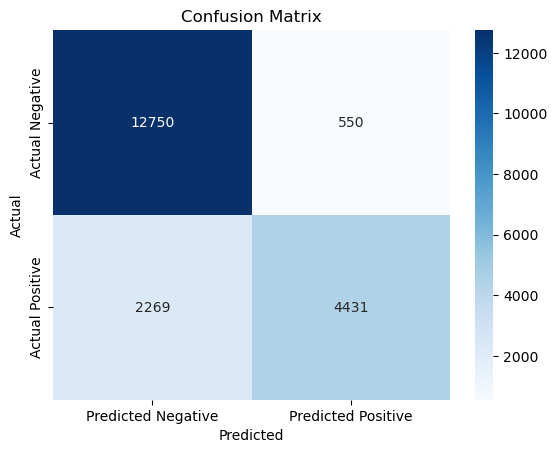

In [13]:
sns.heatmap(all_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Results Visualization

In [14]:
# printing training loss for each fold.
avg_train_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(train_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_train_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Train Loss = {}, Average Train Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Train Loss = 0.1478263196372024, Average Train Accuracy = 0.8521736803627976
Fold 2: Average Train Loss = 0.14355443698650766, Average Train Accuracy = 0.8564455630134924
Fold 3: Average Train Loss = 0.1638162986634969, Average Train Accuracy = 0.8361837013365031
Fold 4: Average Train Loss = 0.1293455385109087, Average Train Accuracy = 0.8706544614890913
Fold 5: Average Train Loss = 0.12189309332047679, Average Train Accuracy = 0.8781069066795232


In [15]:
# printing validation loss for each fold.
avg_val_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(val_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_val_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Validation Loss = {}, Average Validation Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Validation Loss = 0.37608956657921183, Average Validation Accuracy = 0.6239104334207881
Fold 2: Average Validation Loss = 0.5041127109190389, Average Validation Accuracy = 0.49588728908096114
Fold 3: Average Validation Loss = 0.24530639627856055, Average Validation Accuracy = 0.7546936037214395
Fold 4: Average Validation Loss = 0.17328046150552356, Average Validation Accuracy = 0.8267195384944764
Fold 5: Average Validation Loss = 0.4038295171890685, Average Validation Accuracy = 0.5961704828109315


In [16]:
# Printing test set accuracy for each fold.
for value in test_acc_per_fold:
    print(value)

81.8
84.8
92.3
84.025
86.6


In [17]:
# Average accuracy
np.mean(test_acc_per_fold)

85.905

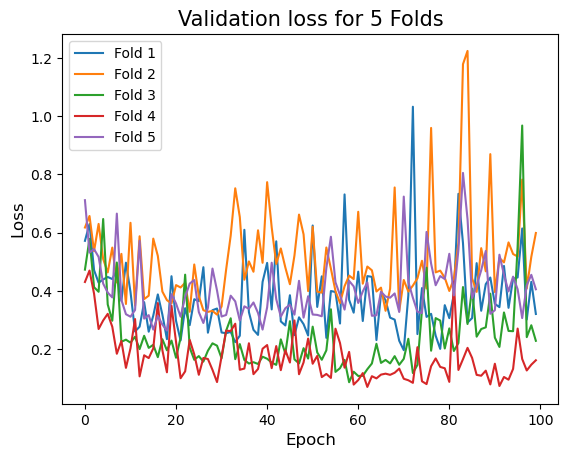

In [18]:
n_folds = len(val_loss_per_fold)
n_epochs = len(val_loss_per_fold[0])

# plot each fold's accuracy as a line plot with a different color
for i in range(n_folds):
    plt.plot(range(n_epochs), val_loss_per_fold[i], label=f"Fold {i+1}")

# set plot title, axis labels, and legend
plt.title("Validation loss for 5 Folds", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()

plt.show()

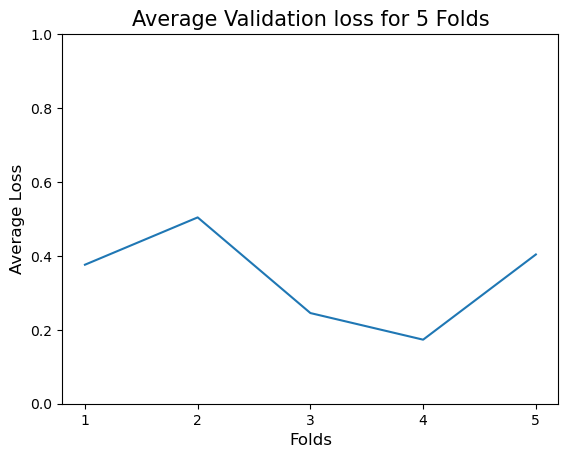

In [19]:
# Plotting the data
plt.plot(range(1, len(avg_val_loss_per_fold) + 1), avg_val_loss_per_fold)
plt.xticks(range(1, len(avg_val_loss_per_fold) + 1))

# Set y-axis range
plt.ylim(0, 1.0)

# Set plot title, axis labels, and legend
plt.title("Average Validation loss for 5 Folds", fontsize=15)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)

# Display the plot
plt.show()

In [20]:
final_model_save_path = r'C:\Users\anikd\Desktop\NC_vs_PAE\final_model_PAE-aug_all_scans_copy1.pth'
torch.save(modified_model.state_dict(), final_model_save_path)